# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Eastenders Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **400 lines** of each character in the training data to create the training documents, and a maximum of the first **40 lines** in the test data (from `test.csv`). This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity based information retrieval based evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-4 below, which you need to complete as instructed.

**Refer to the material in units 7-8 for conceptual background.**

In [1]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfTransformer


%matplotlib inline
pd.options.display.max_colwidth=500

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/razhan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/razhan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/razhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/razhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [3]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # set function is random, need to sort!

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]

print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [4]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [5]:
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [6]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    # may be left out
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.9 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

In [7]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [8]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  3848
OTHER Number of Words:  3244
JACK Number of Words:  4435
RONNIE Number of Words:  3442
TANYA Number of Words:  3786
SEAN Number of Words:  3637
ROXY Number of Words:  3838
HEATHER Number of Words:  4098
MAX Number of Words:  4363
IAN Number of Words:  4332
JANE Number of Words:  3648
STACEY Number of Words:  3913
PHIL Number of Words:  3635
MINTY Number of Words:  4005
CHRISTIAN Number of Words:  3738
CLARE Number of Words:  4344
total words 62306


In [9]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    tokens = character_text.split()   # just a simple tokenization, to be replaced
    return tokens

In [10]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

In [11]:
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    
#     print("sample\n", character_doc)
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    return counts  

In [12]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])
    
#     training_feature_matrix[0].toarray()
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [13]:
training_feature_matrix

<16x8202 sparse matrix of type '<class 'numpy.float64'>'
	with 20749 stored elements in Compressed Sparse Row format>

In [14]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Num of Words:  438
MAX Num of Words:  737
SEAN Num of Words:  366
SHIRLEY Num of Words:  329
OTHER Num of Words:  357
STACEY Num of Words:  412
RONNIE Num of Words:  464
JACK Num of Words:  351
PHIL Num of Words:  475
IAN Num of Words:  508
JANE Num of Words:  458
ROXY Num of Words:  392
HEATHER Num of Words:  411
MINTY Num of Words:  470
CHRISTIAN Num of Words:  489
CLARE Num of Words:  405
total words 7062


In [15]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [16]:
val_feature_matrix

<16x8202 sparse matrix of type '<class 'numpy.float64'>'
	with 3618 stored elements in Compressed Sparse Row format>

In [17]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [18]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [19]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [20]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 4.5
mean cosine similarity 0.9128136458100018
4 correct out of 16 / accuracy: 0.25


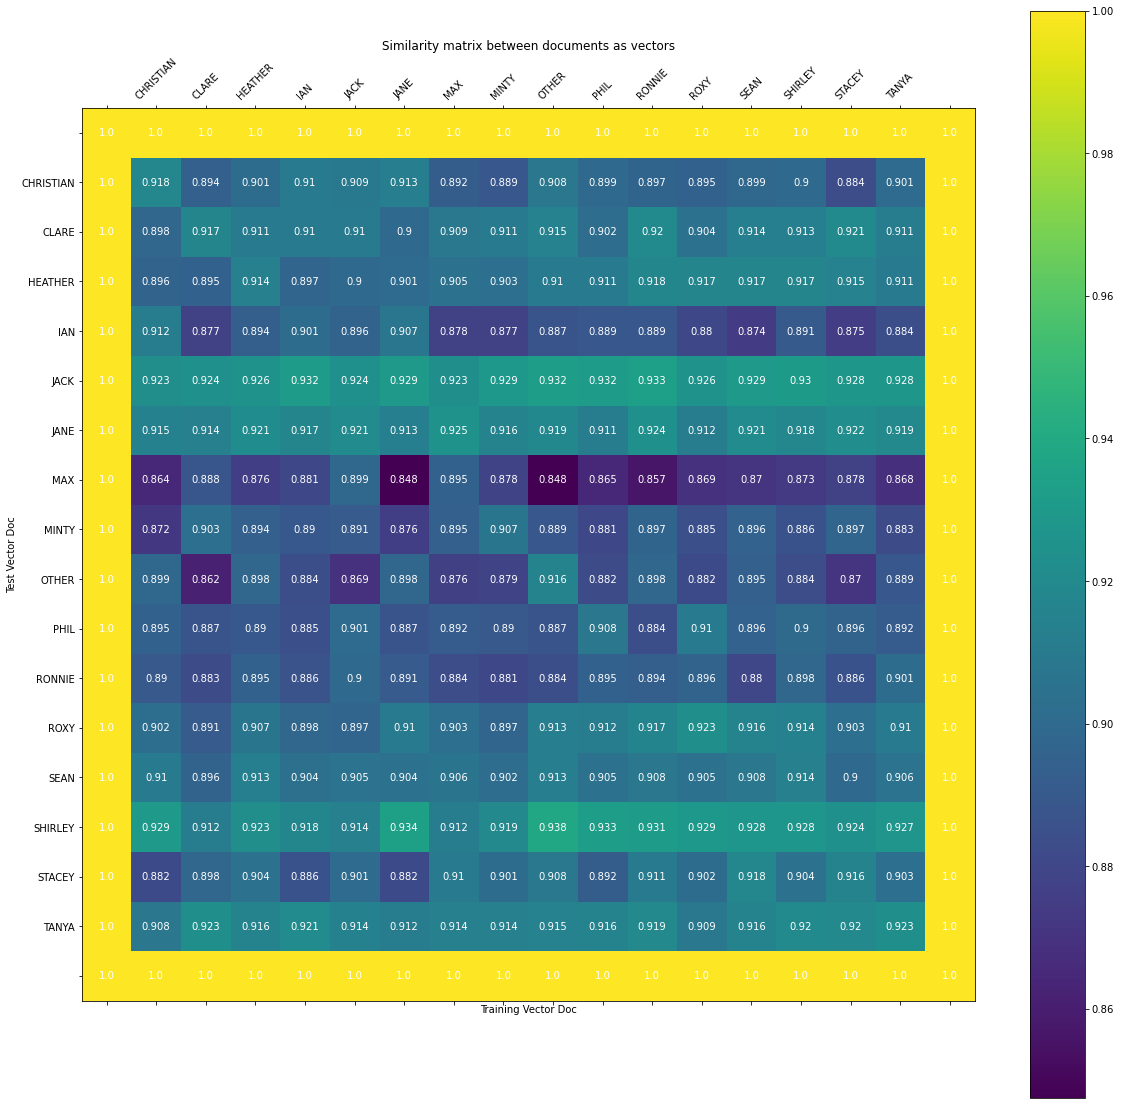

In [21]:
plot_heat_map_similarity(df)

# Q1. Improve pre-processing (10 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the 90% train and 10% validation data split from the training file, using the first 360 lines from the training split and first 40 lines from the validation split, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **16**. Initially the code in this template achieves a mean rank of **5.12**  and accuracy of **0.3125** on the test set- you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


In [22]:
stopwords = stopwords.words('english')

# init lemmatizer
lemmatizer = WordNetLemmatizer()

In [23]:
def decontracted(phrase):
    """
    Function used for solving the contractions for example can't or won't.
    This will help with stop word removal and decreases mean rank by 0.3
    """

    # specific
    phrase = re.sub(r"won\'t|won\’t", "will not", phrase)
    phrase = re.sub(r"can\'t|can\’t", "cannot", phrase)
    phrase = re.sub(r"'cause|’cause", "because", phrase)
    phrase = re.sub(r"c'mon|c’mon", "come on", phrase)
    phrase = re.sub(r"c'mere|c’mere", "come here", phrase)
    phrase = re.sub(r"'course|’course", "of course", phrase)
    phrase = re.sub(r"gimme", "give me", phrase)
    phrase = re.sub(r"gonna", "going to", phrase)
    phrase = re.sub(r"gotta", "got to", phrase)
    phrase = re.sub(r"let's|let’s", "let us", phrase)
    phrase = re.sub(r"'tis|’tis", "it is", phrase)
    phrase = re.sub(r"'twas|’twas", "it was", phrase)
    phrase = re.sub(r"y'all|y’all", "you all", phrase)

    # general
    phrase = re.sub(r"n\'t|n\’t", " not", phrase)
    phrase = re.sub(r"\'re|’re", " are", phrase)
    phrase = re.sub(r"\'s|’s", " is", phrase)
    phrase = re.sub(r"\'d|’d", " would", phrase)
    phrase = re.sub(r"\'ll|’ll", " will", phrase)
    phrase = re.sub(r"\'t|’t", " not", phrase)
    phrase = re.sub(r"\'ve|’ve", " have", phrase)
    phrase = re.sub(r"\'m|’m", " am", phrase)
    return phrase

In [24]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    # Lowercase
#     character_text = character_text.lower()
    
    # Fix contractions
    character_text = decontracted(character_text)
    
#     # Remove punctuations
    character_text = re.sub(r"[^\w\d\s]+", '', character_text)
    
#     # Remove End-of-line
    character_text = re.sub(r'\b_EOL_\b', "", character_text)
    
    # Tokenization
    tokens = word_tokenize(character_text, preserve_line=False)

    
    # Lemmatization 
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Remove stop words
    tokens = [word for word in tokens if word.lower() not in stopwords]

#     print(tokens)
    return tokens

In [25]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [26]:
# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [27]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.625
mean cosine similarity 0.5485160330430644
13 correct out of 16 / accuracy: 0.8125


# Mean rank for each technique 


#### Lower-casing
mean rank 3.25  <br/>
mean cosine similarity 0.9499481211709341  <br/>
7 correct out of 16 / accuracy: 0.4375  <br/>



### Removing punctuation and expanding contraction
mean rank 3.875  <br/>
mean cosine similarity 0.9265230861138908  <br/>
7 correct out of 16 / accuracy: 0.4375  <br/>

### Stopword removal
mean rank 2.875 <br/>
mean cosine similarity 0.9369644543954785 <br/>
11 correct out of 16 / accuracy: 0.6875 <br/>


### Lemmatization
mean rank 2.375  <br/>
mean cosine similarity 0.9418678843515229  <br/>
9 correct out of 16 / accuracy: 0.5625  <br/>


### Removing end-of-line

mean rank 1.625  <br/>
mean cosine similarity 0.5485160330430644 <br/>
13 correct out of 16 / accuracy: 0.8125 <br/>





# Q2. Improve linguistic feature extraction (15 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` function above. Examples of extra features could include extracting n-grams of different lengths and including POS-tags. You could also use sentiment analysis and gender classification (using the same data) as additional features.

You could use some feature selection/reduction with techniques like minimum document frequency and/or feature selection like k-best selection using different criteria https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. Again, develop on 90% training and 10% validation split and note the effect/improvement in mean rank with the techniques you use.

In [28]:
# We are not removinf End-of-line for the second task, 
# we use it to determine a whole sentence and do sentiment analysis on that sentence

def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    # Lowercase
#     character_text = character_text.lower()
    
    # Fix contractions
    character_text = decontracted(character_text)
    
    # Remove punctuations
    character_text = re.sub(r"[^\w\d\s]+", '', character_text)
    
    
    # Tokenization
    tokens = word_tokenize(character_text, preserve_line=False)
    
    # Lemmatization 
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Remove stop words
    tokens = [word for word in tokens if word.lower() not in stopwords]

#     print(tokens)
    return tokens

In [29]:
sia = SentimentIntensityAnalyzer()

def sentiment_analysis(text):
    if sia.polarity_scores(text)["compound"] > 0:
        return "POSITIVE_SENTIMENT"
    else:
        return "NEGATIVE_SENTIMENT"

In [30]:
duplicate_pattern = re.compile(r"/(\b\S+\b)\s+\b\1\b/")
number_pattern = re.compile(r"\d") 

def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    #     counts = Counter(character_doc)  # for now a simple count
    counts = dict()
    
    
    # Check if a character repeats him or herself.
    if re.search(duplicate_pattern, ''.join(character_doc)):
        extra_features.append("DUPLICATE_WORDS")
        
#     Adding pos tag
    token_tag = pos_tag(character_doc)
    character_doc = ['{0}@{1}'.format(t, p) for t, p in token_tag]

#     num_of_sentences = character_doc.count("_EOL_")

    

#     Sentiment analysis without pos tags
#     sentence = []
#     for word in character_doc:
#         # Number
# #         if re.search(number_pattern, word) is not None:
# #             extra_features.append("HAS_NUM")
#         if word == "_EOL_":
#         # sentiment analysis
#             sentiment = sentiment_analysis(" ".join(sentence))
#             extra_features.append(sentiment)
#             sentence = []
#             continue
#         sentence.append(word)
#         counts[word] = counts.get(word, 0) + 1
        

    
    # Sentiment Analysis
    sentence = []
    for token in character_doc:
        if re.search(number_pattern, token) is not None:
            extra_features.append("HAS_NUM")
        word = token.split('@')[0]
        if word == "_EOL_":
            sentiment = sentiment_analysis(" ".join(sentence))
            extra_features.append(sentiment)
            sentence = []
            continue
        sentence.append(word)
        counts[token] = counts.get(token, 0) + 1


    bigrams = nltk.ngrams(character_doc, 2)
    fdist = dict(nltk.FreqDist(bigrams))

    for k,v in fdist.items():
        counts[k[0]+"@"+k[1]] = v
        
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] = counts.get(feature, 0) + 1
        

    return counts 

corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, extra_features=[]) for name, doc in corpus])

    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, extra_features=[]) for name, doc in corpus])
    
#     training_feature_matrix[0].toarray()
    return doc_feature_matrix

In [31]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [32]:
# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [33]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 2.4375
mean cosine similarity 0.861424925759332
11 correct out of 16 / accuracy: 0.6875


In [34]:
best_features = SelectKBest(chi2, k=140)
training_k_feature_matrix = best_features.fit_transform(training_feature_matrix, train_labels)
val_k_feature_matrix = best_features.transform(val_feature_matrix)


In [35]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_k_feature_matrix, val_k_feature_matrix, train_labels, val_labels)

mean rank 1.4375
mean cosine similarity 0.57961360077816
12 correct out of 16 / accuracy: 0.75


In [36]:
corpusVectorizer.vocabulary_["POSITIVE_SENTIMENT"]

3444

# Mean rank for each feature

#### POS TAG feature

mean rank 2.4375<br/>
mean cosine similarity 0.8984705730522884<br />
10 correct out of 16 / accuracy: 0.625<br />


### Sentiment analysis

mean rank 2.6875<br/>
mean cosine similarity 0.8961616035174903<br/>
10 correct out of 16 / accuracy: 0.625<br/>

### Bigram
mean rank 2.125<br/>
mean cosine similarity 0.2972694659089822 <br/>
10 correct out of 16 / accuracy: 0.625 <br/>


### HasNUM
mean rank 2.4375 <br/>
mean cosine similarity 0.9427679614769604 <br/>
10 correct out of 16 / accuracy: 0.625 <br/>

### All features 

mean rank 2.4375 <br/>
mean cosine similarity 0.861424925759332 <br/>
11 correct out of 16 / accuracy: 0.6875 <br/>


### SelectKbest (k=140)
mean rank 1.4375 <br/>
mean cosine similarity 0.57961360077816 <br/>
12 correct out of 16 / accuracy: 0.75 <br/>



# Q3. Add dialogue context data and features (15 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (immediately before and after). You can also use **scene information** from the other columns **(but NOT the gender and character names directly)**.

In [37]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    
    visited_scene = {}
    for idx,(line, name, gender,scene, scene_info) in enumerate(zip(df.Line, df.Character_name, df.Gender,df.Scene, df.Scene_info)):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
            visited_scene[name] = []
        
        if character_line_count[name] == max_line_count:
            continue
            
        if scene_info not in visited_scene[name]:
            character_docs[name] += str(scene_info).replace(" ","")   + " _END_SCENE_ "
        
        if (idx > 0) and (df.iloc[idx-1].Scene == df.iloc[idx].Scene):
            character_docs[name] += str(df.iloc[idx-1].Line) + " _PEOL_ "
        
        character_docs[name] += str(line) + " _EOL_ " # adding an end-of-line token
        character_line_count[name]+=1
        
        if (idx < len(df)-1) and (df.iloc[idx].Scene == df.iloc[idx+1].Scene):
            character_docs[name] += str(df.iloc[idx+1].Line) + " _NEOL_ "
        
        
        visited_scene[name].append((scene_info))
    print("lines per character", character_line_count)
    return character_docs

In [38]:
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  10661
OTHER Number of Words:  8939
JACK Number of Words:  10849
RONNIE Number of Words:  11031
TANYA Number of Words:  10357
SEAN Number of Words:  10338
ROXY Number of Words:  10858
HEATHER Number of Words:  11502
MAX Number of Words:  10932
IAN Number of Words:  11369
JANE Number of Words:  10805
STACEY Number of Words:  10913
PHIL Number of Words:  11683
MINTY Number of Words:  11758
CHRISTIAN Number of Words:  10510
CLARE Number of Words:  10907
total words 173412
lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Nu

In [39]:
train_character_docs["JACK"]

"R&RINTNIGHT _END_SCENE_ Oi. Where have you been? Huh? What were the texts about? _EOL_ Nothing. Nothing. I'll be with you in two minutes yeah? _NEOL_ Nothing. Nothing. I'll be with you in two minutes yeah? _PEOL_ Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar. _EOL_ Alright. Two minutes. _NEOL_ It's on the house. Are you alright? _EOL_ Yep. _NEOL_ Yep. _PEOL_ I left the night wallet at home. I'm gonna be about ten minutes. _EOL_ Okay. _NEOL_ Okay. _PEOL_ Are you alright? You've been a bit off since you got here. _EOL_ Are you alright? _NEOL_ R&ROFFICEINTNIGHT _END_SCENE_ So that's why you were late? You had a little set up planned? _EOL_ Proper little detective aren't you? _NEOL_ Proper little detective aren't you? _PEOL_ Well, how about I pour you a glass of this and take you through what might've happened. So, I would've given you this. Then what? _EOL_ I'd have drunk it. _NEOL_ I'd have drunk it. _PEOL_ And then? _EOL_ I'm doing

In [40]:

def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    # Lowercase
#     character_text = character_text.lower()
    
    # Fix contractions
    character_text = decontracted(character_text)
    
    # Remove punctuations
    character_text = re.sub(r"[^\w\d\s]+", '', character_text)
    
    
    # Tokenization
    tokens = word_tokenize(character_text, preserve_line=False)
    
    # Lemmatization 
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Remove stop words
    tokens = [word for word in tokens if word.lower() not in stopwords]

#     print(tokens)
    return tokens

In [41]:
duplicate_pattern = re.compile(r"/(\b\S+\b)\s+\b\1\b/")
number_pattern = re.compile(r"\d") 

def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
#     counts = Counter(character_doc)  # for now a simple count
    counts = dict()
    
    
    # Check if a character repeats him or herself.
#     if re.search(duplicate_pattern, ''.join(character_doc)):
#         extra_features.append("DUPLICATE_WORDS")
        
#     Adding pos tag
#     token_tag = pos_tag(character_doc)
#     character_doc = ['{0}@{1}'.format(t, p) for t, p in token_tag]

    num_of_sentences = character_doc.count("_EOL_")


    
    # Sentiment Analysis
    sentence = []
    for idx, word in enumerate(character_doc):
#         word = token.split('@')[0]
        
        # scene info is stripped of white space so the word before _END_SCENE_ is the whole scene name
        if word == "_END_SCENE_":
            extra_features.append("SCENE_" + str(character_doc[idx-1]))
            continue
            
        if word == "_PEOL_":
            extra_features.append("PREV_" + "".join(sentence))
            sentence = []
            continue
            
#         if word == "_NEOL_":
#             extra_features.append("NEXT_" + "".join(sentence))
#             sentence = []
#             continue
            
        if re.search(number_pattern, word) is not None:
            extra_features.append("HAS_NUM")
            
            
        if word == "_EOL_":
            sentiment = sentiment_analysis(" ".join(sentence))
            extra_features.append(sentiment)
            sentence = []
            continue
        sentence.append(word)
#         counts[token] = counts.get(token, 0) + 1
        counts[word] = counts.get(word, 0) + 1


    bigrams = nltk.ngrams(character_doc, 2)
    fdist = dict(nltk.FreqDist(bigrams))

    for k,v in fdist.items():
        counts[k[0]+"@"+k[1]] = v
        
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] = counts.get(feature, 0) + 1
        

    return counts 

corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, extra_features=[]) for name, doc in corpus])

    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, extra_features=[]) for name, doc in corpus])
    
#     training_feature_matrix[0].toarray()
    return doc_feature_matrix

In [42]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [43]:
# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [44]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.4375
mean cosine similarity 0.8218945422642137
11 correct out of 16 / accuracy: 0.6875


In [45]:
best_features = SelectKBest(chi2, k=400)
training_k_feature_matrix = best_features.fit_transform(training_feature_matrix, train_labels)
val_k_feature_matrix = best_features.transform(val_feature_matrix)


In [46]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_k_feature_matrix, val_k_feature_matrix, train_labels, val_labels)

mean rank 1.1875
mean cosine similarity 0.684690060560543
13 correct out of 16 / accuracy: 0.8125


# Q4. Improve the vectorization method (10 marks)
Use a matrix transformation technique like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizor (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

As the `create_document_matrix_from_corpus` is designed to be used both in training/fitting (with `fitting` set to `True`) and in transformation alone on test/validation data (with `fitting` set to `False`), make sure you initialize any transformers you want to try in the same place as `corpusVectorizer = DictVectorizer()` before you call 
`create_document_matrix_from_corpus`. Again, develop on 90% training 10% validation split and note the effect/improvement in mean rank with each technique you try.

In [47]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    
    visited_scene = {}
    for idx,(line, name, gender,scene, scene_info) in enumerate(zip(df.Line, df.Character_name, df.Gender,df.Scene, df.Scene_info)):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
            visited_scene[name] = []
        
        if character_line_count[name] == max_line_count:
            continue
            
        if scene_info not in visited_scene[name]:
            character_docs[name] += str(scene_info).replace(" ","")   + " _END_SCENE_ "
        
        if (idx > 0) and (df.iloc[idx-1].Scene == df.iloc[idx].Scene):
            character_docs[name] += str(df.iloc[idx-1].Line) + " _PEOL_ "
        
        character_docs[name] += str(line) + " _EOL_ " # adding an end-of-line token
        character_line_count[name]+=1
        
        if (idx < len(df)-1) and (df.iloc[idx].Scene == df.iloc[idx+1].Scene):
            character_docs[name] += str(df.iloc[idx+1].Line) + " _NEOL_ "
        
        
        visited_scene[name].append((scene_info))
    print("lines per character", character_line_count)
    return character_docs

In [48]:
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}


In [49]:

def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    # Lowercase
    character_text = character_text.lower()
    
    # Fix contractions
    character_text = decontracted(character_text)
    
    # Remove punctuations
    character_text = re.sub(r"[^\w\d\s]+", '', character_text)
    
    # Remove End-of-line
    character_text = re.sub(r'\b_EOL_\b', "", character_text)
    
    # Tokenization
    tokens = word_tokenize(character_text, preserve_line=False)
    
    # Lemmatization 
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Remove stop words
    tokens = [word for word in tokens if word.lower() not in stopwords]

#     print(tokens)
    return tokens

In [50]:
duplicate_pattern = re.compile(r"/(\b\S+\b)\s+\b\1\b/")
number_pattern = re.compile(r"\d") 

def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
#     counts = Counter(character_doc)  # for now a simple count
    counts = dict()
    
    
    # Check if a character repeats him or herself.
#     if re.search(duplicate_pattern, ''.join(character_doc)):
#         extra_features.append("DUPLICATE_WORDS")
        
#     Adding pos tag
#     token_tag = pos_tag(character_doc)
#     character_doc = ['{0}@{1}'.format(t, p) for t, p in token_tag]

    num_of_sentences = character_doc.count("_EOL_")


    
    # Sentiment Analysis
    sentence = []
    for idx, word in enumerate(character_doc):
#         word = token.split('@')[0]
        
        # scene info is stripped of white space so the word before _END_SCENE_ is the whole scene name
        if word == "_END_SCENE_":
            extra_features.append("SCENE_" + str(character_doc[idx-1]))
            continue
            
        if word == "_PEOL_":
            extra_features.append("PREV_" + "".join(sentence))
            sentence = []
            continue
            
#         if word == "_NEOL_":
#             extra_features.append("NEXT_" + "".join(sentence))
#             sentence = []
#             continue
            
        if re.search(number_pattern, word) is not None:
            extra_features.append("HAS_NUM")
            
            
        if word == "_EOL_":
            sentiment = sentiment_analysis(" ".join(sentence))
            extra_features.append(sentiment)
            sentence = []
            continue
        sentence.append(word)
#         counts[token] = counts.get(token, 0) + 1
        counts[word] = counts.get(word, 0) + 1


    bigrams = nltk.ngrams(character_doc, 2)
    fdist = dict(nltk.FreqDist(bigrams))

    for k,v in fdist.items():
        counts[k[0]+"@"+k[1]] = v
        
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] = counts.get(feature, 0) + 1
        

    return counts 


In [51]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
corpusTransformer = TfidfTransformer()

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q4.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    vectorizer_inp = [to_feature_vector_dictionary(doc,extra_features=[]) for name, doc in corpus]
    if fitting:
        corpusVectorizer.fit(vectorizer_inp)
    doc_feature_matrix = corpusVectorizer.transform(vectorizer_inp)

    if fitting:
        corpusTransformer.fit(doc_feature_matrix)  
    doc_feature_matrix = corpusTransformer.transform(doc_feature_matrix)

    return doc_feature_matrix



In [52]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [53]:
# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [54]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.4375
mean cosine similarity 0.7227931699681773
10 correct out of 16 / accuracy: 0.625


In [55]:
best_features = SelectKBest(chi2, k=1000)
training_k_feature_matrix = best_features.fit_transform(training_feature_matrix, train_labels)
val_k_feature_matrix = best_features.transform(val_feature_matrix)


In [56]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_k_feature_matrix, val_k_feature_matrix, train_labels, val_labels)

mean rank 1.25
mean cosine similarity 0.510751335605835
12 correct out of 16 / accuracy: 0.75


# Q5. Select and test the best vector representation method (10 marks)
Finish the optimization of your vector representations by selecting the best combination of the techniques you tried in Q1-3 and test using the code below to train on all of the training data (using the first 400 lines per character maximum) and do the final testing on the test file (using the first 40 lines per character maximum).

Make any neccessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank, accuracy of document selection are on the test data.

In [57]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [58]:

def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    # Lowercase
#     character_text = character_text.lower()
    
    # Fix contractions
    character_text = decontracted(character_text)
    
    # Remove punctuations
    character_text = re.sub(r"[^\w\d\s]+", '', character_text)
    
    # Remove End-of-line
#     character_text = re.sub(r'\b_EOL_\b', "", character_text)
    
    # Tokenization
    tokens = word_tokenize(character_text, preserve_line=False)
    
    # Lemmatization 
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Remove stop words
    tokens = [word for word in tokens if word.lower() not in stopwords]

#     print(tokens)
    return tokens

In [59]:
duplicate_pattern = re.compile(r"/(\b\S+\b)\s+\b\1\b/")
number_pattern = re.compile(r"\d") 

def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
    counts = dict()
    
    
    # Check if a character repeats him or herself.
#     if re.search(duplicate_pattern, ''.join(character_doc)):
#         extra_features.append("DUPLICATE_WORDS")
        
#     Adding pos tag
    token_tag = pos_tag(character_doc)
    character_doc = ['{0}@{1}'.format(t, p) for t, p in token_tag]


    # Sentiment analysis without pos tags
#     sentence = []
#     for word in character_doc:
        # Number
#         if re.search(number_pattern, word) is not None:
#             extra_features.append("HAS_NUM")
#         if word == "_EOL_":
#         # sentiment analysis
#             sentiment = sentiment_analysis(" ".join(sentence))
#             extra_features.append(sentiment)
#             sentence = []
#             continue
#         sentence.append(word)
#         counts[word] = counts.get(word, 0) + 1
        

    
    # Sentiment Analysis
    sentence = []
    for token in character_doc:
#         if re.search(number_pattern, token) is not None:
#             extra_features.append("HAS_NUM")
        word = token.split('@')[0]
        if word == "_EOL_":
            sentiment = sentiment_analysis(" ".join(sentence))
            extra_features.append(sentiment)
            sentence = []
            continue
        sentence.append(word)
        counts[token] = counts.get(token, 0) + 1


#     bigrams = nltk.ngrams(character_doc, 2)
#     fdist = dict(nltk.FreqDist(bigrams))

#     for k,v in fdist.items():
#         counts[k[0]+"@"+k[1]] = v
        
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] = counts.get(feature, 0) + 1
        

    return counts 


In [60]:
# corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# # Any matrix transformers (e.g. tf-idf transformers) should be initialized here
# corpusTransformer = TfidfTransformer()

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q4.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    vectorizer_inp = [to_feature_vector_dictionary(doc,extra_features=[]) for name, doc in corpus]
    if fitting:
        corpusVectorizer.fit(vectorizer_inp)
    doc_feature_matrix = corpusVectorizer.transform(vectorizer_inp)

    if fitting:
        corpusTransformer.fit(doc_feature_matrix)  
    doc_feature_matrix = corpusTransformer.transform(doc_feature_matrix)

    return doc_feature_matrix


In [61]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
corpusTransformer = TfidfTransformer()

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

best_features = SelectKBest(chi2, k=360)
training_k_feature_matrix = best_features.fit_transform(training_feature_matrix, train_labels)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)
test_k_feature_matrix = best_features.transform(test_feature_matrix)

# mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_k_feature_matrix, test_k_feature_matrix, train_labels, test_labels)

lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
Num. Characters:  16 

SHIRLEY Number of Words:  4233
OTHER Number of Words:  3606
JACK Number of Words:  4786
RONNIE Number of Words:  3872
TANYA Number of Words:  4214
SEAN Number of Words:  4026
ROXY Number of Words:  4200
HEATHER Number of Words:  4504
MAX Number of Words:  5107
IAN Number of Words:  4863
JANE Number of Words:  4117
STACEY Number of Words:  4325
PHIL Number of Words:  4103
MINTY Number of Words:  4391
CHRISTIAN Number of Words:  4250
CLARE Number of Words:  4844
total words 69441
lines per character {'SHIRLEY': 40, 'OTHER': 40, 'HEATHER': 40, 'PHIL': 40, 'SEAN': 40, 'TANYA': 40, 'MAX': 40, 'JACK': 40, 'IAN': 40, 'JANE': 40, 'STACEY': 40, 'ROXY': 40, 'RONNIE': 40, 'CHRISTIAN': 40, 'MINTY': 40, 'CLARE': 40}
Num. Characters:  